# Proton NMR - Technical

## Imports and Definitions

In [1]:
# python modules
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from glob import glob
from scipy.optimize import curve_fit, minimize
from allantools import oadev
from glob import glob

# external function definitions
from nmrLib import *

# plot settings, increase font sizes
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['legend.labelspacing'] = 0.2

In [3]:
if 5 > 3:
    print("Five is greater than three!)

SyntaxError: EOL while scanning string literal (<ipython-input-3-99f06ab4ecbd>, line 2)

## Pump Flow Rate

In [2]:
# load the data from the file
data = np.loadtxt('data/pumpFlowRate.txt')

# control voltage for the pump power in [V]
controlVoltage = data[:,0]

# time that the water was collected in [s]
pumpTime = np.array([30,0.5])

# tube radius in [m]
tubeRadius = 0.002

In [3]:
# weight of the collected water in [g]
pumpVolume = data[:,1:]

pumpVolume = np.array([pumpVolume.mean(axis=1), pumpVolume.std(axis=1)])

# flow velocity through interaction region in [m/s]
flowVelocity = 1e-6*np.array([pumpVolume[0]/pumpTime[0]/(tubeRadius**2*np.pi), 
                              np.sqrt(pumpVolume[1]**2/pumpTime[0]**2/tubeRadius**4/np.pi**2 + pumpVolume[0]**2*pumpTime[1]**2/pumpTime[0]**4/tubeRadius**4/np.pi**2)])

# flow rate of pump in [l/min]
flowRate = 60/1000*np.array([pumpVolume[0]/pumpTime[0], 
                             np.sqrt(pumpVolume[1]**2/pumpTime[0]**2 + pumpVolume[0]**2*pumpTime[1]**2/pumpTime[0]**4)])

In [4]:
popt, pcov = np.polyfit(controlVoltage, flowVelocity[0], 1, w=1/flowVelocity[1], cov='unscaled')
perr = np.sqrt(np.diag(pcov))
print('{:.02f} +/- {:.02f} m/s/V'.format(popt[0], perr[0]))

popt, pcov = np.polyfit(controlVoltage, flowRate[0], 1, w=1/flowRate[1], cov='unscaled')
perr = np.sqrt(np.diag(pcov))
print('{:.02f} +/- {:.02f} l/min/V'.format(popt[0], perr[0]))

0.71 +/- 0.02 m/s/V
0.53 +/- 0.02 l/min/V


2.0 V: 1.27 m/s
2.5 V: 1.63 m/s
3.0 V: 2.03 m/s
3.5 V: 2.35 m/s
4.0 V: 2.65 m/s


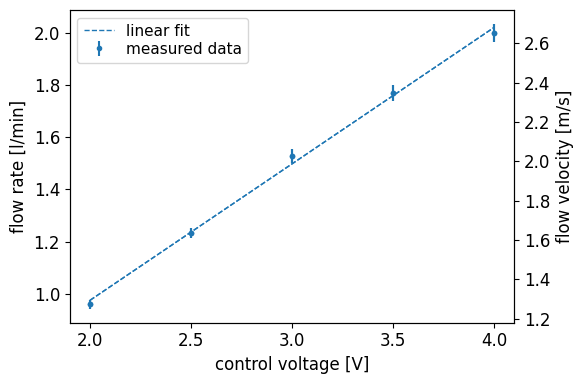

In [5]:
for i,(u,v) in enumerate(zip(controlVoltage, flowVelocity[0])):
    print('{} V: {:.02f} m/s'.format(u,v))


fig, ax = plt.subplots()

ax.errorbar(controlVoltage, flowRate[0], flowRate[1], fmt='C0.', label='measured data')
ax.plot(controlVoltage, np.polyval(np.polyfit(controlVoltage, flowRate[0], 1), controlVoltage), 'C0--', lw=1, label='linear fit')
ax.set(xlabel='control voltage [V]', ylabel='flow rate [l/min]')

ax2 = ax.twinx()
ax2.errorbar(controlVoltage, flowVelocity[0], flowVelocity[1], fmt='C0.')
ax2.plot(controlVoltage, np.polyval(np.polyfit(controlVoltage, flowVelocity[0], 1), controlVoltage), 'C0--', lw=1)
ax2.set(ylabel='flow velocity [m/s]')

ax.legend()
fig.set(dpi=100)
fig.tight_layout()

plt.show()

## NMR Signal

sampling interval:	7.8125 us
exponential decay time:	(155 +/- 7) us


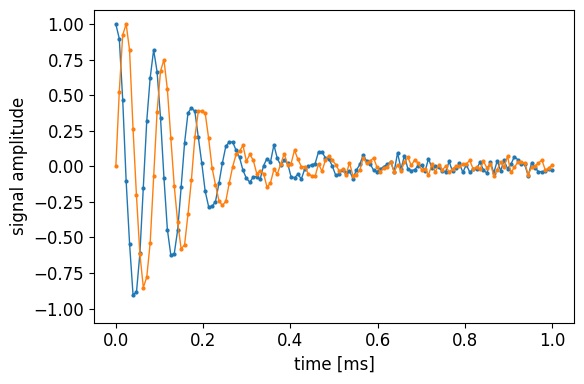

In [35]:
file = 'data/nmrSignal.txt'

# spectral width in [Hz]
specWidth = 128e3

# sampling interval in [s]
tdwell = 1/specWidth
print('sampling interval:\t{} us'.format(1e6*tdwell))

# load the signal from the data file
sig = pd.read_csv(file, skiprows=12)
sig = (np.asarray(sig['[DATA]'][::2]) + 1.j*np.asarray(sig['[DATA]'][1::2]))

# create the time array
time = np.linspace(0, len(sig)*tdwell, len(sig))

# normalize the signal
sig = sig/sig.max()



popt = (12e3, 1, 90, 2e-4)
popt, pcov = curve_fit(nmrSignal, time, sig.real, p0=popt)
perr = np.sqrt(np.diag(pcov))
print('exponential decay time:\t({:.0f} +/- {:.0f}) us'.format(popt[3]*1e6, perr[3]*1e6))

fig, ax = plt.subplots()
ax.plot(time*1e3, sig.real, 'C0.-', ms=4, lw=1)
#ax.plot(time*1e3, nmrSignal(time, *popt), 'C0-', lw=1)
ax.plot(time*1e3, sig.imag, 'C1.-', ms=4, lw=1)
ax.set(xlabel='time [ms]', ylabel='signal amplitude', ylim=(-1.1, 1.1))
fig.set(dpi=100)
fig.tight_layout()
plt.show()

## NMR Spectrum

X² / NDF:	1058 / 251 = 4.2
T2*:		(148 +/- 2) us


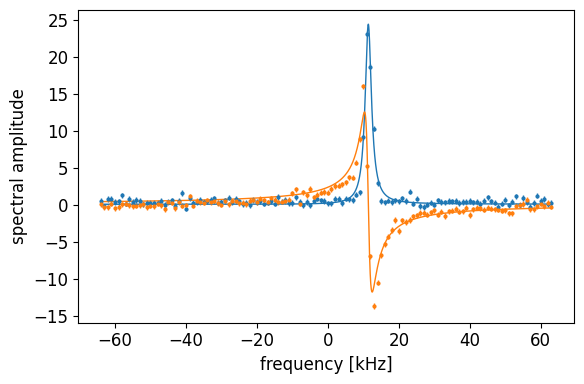

In [64]:
freq = np.fft.fftshift(np.fft.fftfreq(len(sig), d=tdwell))
spec = np.fft.fftshift(np.fft.fft(sig, n=len(sig), norm=None))
noise = spec[:len(spec)//2].real.std()
idx_max = 76
popt = (freq[idx_max],1e3*spec[idx_max].real,0.001,0,0)

popt, pcov = curve_fit(lorentzFitFct, np.hstack([freq,freq]), np.hstack([spec.real, spec.imag]), 
                       sigma=noise*np.ones(2*len(spec)), absolute_sigma=True, p0=popt, maxfev=100000)
perr = np.sqrt(np.diag(pcov))
chi2 = np.sum((np.hstack([spec.real, spec.imag])-lorentzFitFct(np.hstack([freq,freq]), *popt))**2 / (noise*np.ones(2*len(spec)))**2)
chi2_r = chi2 / (2*len(spec) - len(popt))

print('X² / NDF:\t{:.0f} / {} = {:.1f}'.format(chi2, (2*len(spec) - len(popt)), chi2_r))
print('T2*:\t\t({:.0f} +/- {:.0f}) us'.format(1e6*popt[2]/2/np.pi, 1e6*perr[2]/2/np.pi))

freqFit = np.linspace(freq.min(), freq.max(), 10001)

    
fig, ax = plt.subplots()
ax.errorbar(freq/1e3, spec.real, noise, fmt='C0.', ms=4, lw=1)
ax.plot(freqFit/1e3, lorentzFct(freqFit, *popt).real, 'C0-', lw=1)    
ax.errorbar(freq/1e3, spec.imag, noise, fmt='C1.', ms=4, lw=1)
ax.plot(freqFit/1e3, lorentzFct(freqFit, *popt).imag, 'C1-', lw=1)
ax.set(xlabel='frequency [kHz]', ylabel='spectral amplitude')
fig.set(dpi=100)
fig.tight_layout()
plt.show()

In [66]:
for i in range(len(popt)):
    print(popt[i], perr[i])

11367.059642766595 17.22281102456551
26171.244079445874 301.3295693874411
0.0009275935415354237 1.49713554450263e-05
-1.3895766572579855 0.6463819624333379
0.13173211663979856 0.02280800256612453


X² / NDF:	296 / 124 = 2.4
T2*:		(168.9 +/- 4.9) us


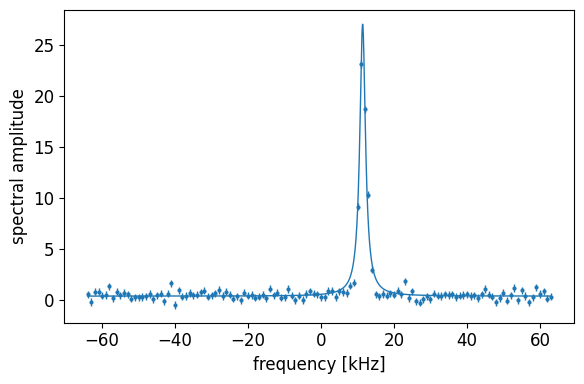

In [56]:
freq = np.fft.fftshift(np.fft.fftfreq(len(sig), d=tdwell))
spec = np.fft.fftshift(np.fft.fft(sig, n=len(sig), norm=None))
noise = spec[:len(spec)//2].real.std()
idx_max = 76
popt = (freq[idx_max],1e3*spec[idx_max].real,0.001,0)

popt, pcov = curve_fit(lorentzAbsFct, freq, spec.real, 
                       sigma=noise*np.ones(len(spec)), absolute_sigma=True, p0=popt, maxfev=100000)
perr = np.sqrt(np.diag(pcov))
chi2 = np.sum((spec.real-lorentzAbsFct(freq, *popt))**2 / (noise*np.ones(len(spec)))**2)
chi2_r = chi2 / (len(spec) - len(popt))

print('X² / NDF:\t{:.0f} / {} = {:.1f}'.format(chi2, (len(spec) - len(popt)), chi2_r))
print('T2*:\t\t({:.1f} +/- {:.1f}) us'.format(1e6*popt[2]/2/np.pi, 1e6*perr[2]/2/np.pi))

freqFit = np.linspace(freq.min(), freq.max(), 10001)

    
fig, ax = plt.subplots()
ax.errorbar(freq/1e3, spec.real, noise, fmt='C0.', ms=4, lw=1)
ax.plot(freqFit/1e3, lorentzAbsFct(freqFit, *popt).real, 'C0-', lw=1)    
ax.set(xlabel='frequency [kHz]', ylabel='spectral amplitude')
fig.set(dpi=100)
fig.tight_layout()
plt.show()

<ErrorbarContainer object of 3 artists>

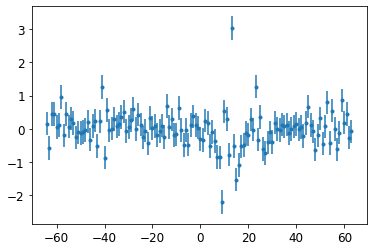

In [57]:
plt.errorbar(freq/1e3, spec.real-lorentzAbsFct(freq, *popt), noise, fmt='.')

In [61]:
np.mean(spec.real-lorentzAbsFct(freq, *popt)), np.std(spec.real-lorentzAbsFct(freq, *popt))

(-6.087153697764691e-09, 0.5400909476230162)

(array([ 1.,  0.,  1.,  0.,  1.,  5., 16., 20., 44., 21., 12.,  3.,  1.,
         2.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-2.20984939, -1.94755705, -1.68526471, -1.42297236, -1.16068002,
        -0.89838768, -0.63609533, -0.37380299, -0.11151065,  0.1507817 ,
         0.41307404,  0.67536639,  0.93765873,  1.19995107,  1.46224342,
         1.72453576,  1.9868281 ,  2.24912045,  2.51141279,  2.77370513,
         3.03599748]),
 <BarContainer object of 20 artists>)

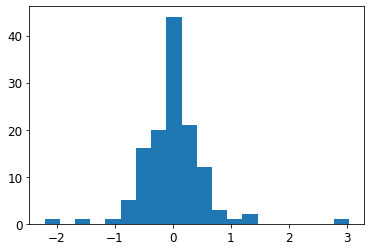

In [59]:
plt.hist(spec.real-lorentzAbsFct(freq, *popt), 20)

## Rabi Measurements

### Resonances for Various Flow Rates

resonance at 502.2(2) Hz
resonance width 29.5(2) Hz
FWHM 69.4(5) Hz
reduced chi-squared: 1.79

resonance at 502.8(1) Hz
resonance width 33.7(2) Hz
FWHM 79.3(5) Hz
reduced chi-squared: 4.10

resonance at 503.5(1) Hz
resonance width 38.7(2) Hz
FWHM 91.0(6) Hz
reduced chi-squared: 3.09

resonance at 503.9(2) Hz
resonance width 43.3(3) Hz
FWHM 101.9(6) Hz
reduced chi-squared: 2.06



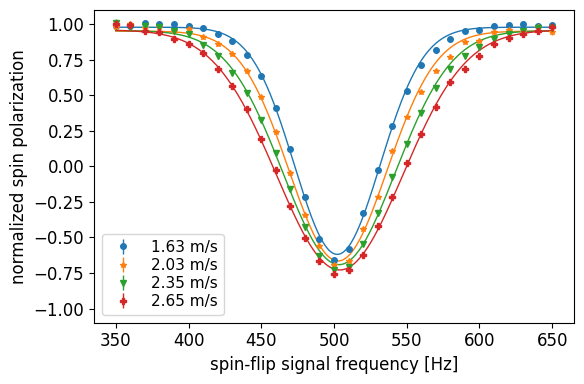

In [9]:
fig, ax = plt.subplots()

popt, perr = plotRabiFrequencyScan('data/rabiFrequencyScan_SF1_2500mV_0050mA_20220303/', ax=ax, lc='C0', marker='o', ms=4, label='1.63 m/s')
popt, perr = plotRabiFrequencyScan('data/rabiFrequencyScan_SF1_3000mV_0050mA_20220303/', ax=ax, lc='C1', marker='*', ms=4, label='2.03 m/s')
popt, perr = plotRabiFrequencyScan('data/rabiFrequencyScan_SF1_3500mV_0050mA_20220303/', ax=ax, lc='C2', marker='v', ms=4, label='2.35 m/s')
popt, perr = plotRabiFrequencyScan('data/rabiFrequencyScan_SF1_4000mV_0050mA_20220303/', ax=ax, lc='C3', marker='P', ms=4, label='2.65 m/s')

ax.legend()
ax.set(xlabel='spin-flip signal frequency [Hz]', ylabel='normalized spin polarization', ylim=(-1.1,1.1))

fig.set(dpi=100)
fig.tight_layout()

plt.show()

### Resonances at Various Frequencies

resonance at 259.0(1) Hz
resonance width 38.6(2) Hz
FWHM 91.0(5) Hz
reduced chi-squared: 2.75

resonance at 503.5(1) Hz
resonance width 38.7(2) Hz
FWHM 91.0(6) Hz
reduced chi-squared: 3.09

resonance at 996.1(1) Hz
resonance width 38.8(2) Hz
FWHM 91.4(5) Hz
reduced chi-squared: 2.33

resonance at 1983.1(1) Hz
resonance width 38.7(2) Hz
FWHM 91.0(5) Hz
reduced chi-squared: 3.85



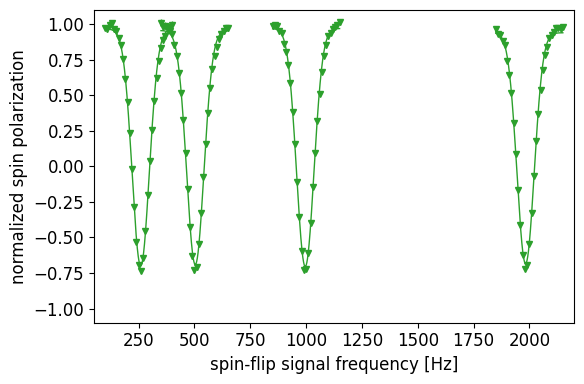

In [10]:
fig, ax = plt.subplots()

plotRabiFrequencyScan('data/rabiFrequencyScan_SF1_3500mV_0025mA_20220303/', ax=ax, lc='C2', marker='v', ms=4, label='25 mA', center=False, p0=(250,-100,50,1))
plotRabiFrequencyScan('data/rabiFrequencyScan_SF1_3500mV_0050mA_20220303/', ax=ax, lc='C2', marker='v', ms=4, label='50 mA', center=False, p0=(500,-100,50,1))
plotRabiFrequencyScan('data/rabiFrequencyScan_SF1_3500mV_0100mA_20220303/', ax=ax, lc='C2', marker='v', ms=4, label='100 mA', center=False, p0=(1000,-100,50,1))
plotRabiFrequencyScan('data/rabiFrequencyScan_SF1_3500mV_0200mA_20220303/', ax=ax, lc='C2', marker='v', ms=4, label='200 mA', center=False, p0=(2000,-100,50,1))

ax.set(xlabel='spin-flip signal frequency [Hz]', ylabel='normalized spin polarization', xlim=(50, 2200), ylim=(-1.1,1.1))

fig.set(dpi=100)
fig.tight_layout()

plt.show()

In [11]:
fwhm_scaling = 2*np.sqrt(2*np.log(2))

resWidth = []

popt, perr = plotRabiFrequencyScan('data/rabiFrequencyScan_SF1_3500mV_0025mA_20220303/', lc='C0', label='25 mA', center=False, p0=(250,-100,50,1))
resWidth.append([fwhm_scaling*popt[2], fwhm_scaling*perr[2]])

popt, perr = plotRabiFrequencyScan('data/rabiFrequencyScan_SF1_3500mV_0050mA_20220303/', lc='C1', label='50 mA', center=False, p0=(500,-100,50,1))
resWidth.append([fwhm_scaling*popt[2], fwhm_scaling*perr[2]])

popt, perr = plotRabiFrequencyScan('data/rabiFrequencyScan_SF1_3500mV_0100mA_20220303/', lc='C2', label='100 mA', center=False, p0=(1000,-100,50,1))
resWidth.append([fwhm_scaling*popt[2], fwhm_scaling*perr[2]])

popt, perr = plotRabiFrequencyScan('data/rabiFrequencyScan_SF1_3500mV_0200mA_20220303/', lc='C3', label='200 mA', center=False, p0=(2000,-100,50,1))
resWidth.append([fwhm_scaling*popt[2], fwhm_scaling*perr[2]])

popt, perr = plotRabiFrequencyScan('data/rabiFrequencyScan_SF1_3500mV_0404mA_20220303/', lc='C4', label='404 mA', center=False, p0=(4000,-100,50,1))
resWidth.append([fwhm_scaling*popt[2], fwhm_scaling*perr[2]])

popt, perr = plotRabiFrequencyScan('data/rabiFrequencyScan_SF1_3500mV_0505mA_20220303/', lc='C5', label='505 mA', center=False, p0=(5000,-100,50,1))
resWidth.append([fwhm_scaling*popt[2], fwhm_scaling*perr[2]])

popt, perr = plotRabiFrequencyScan('data/rabiFrequencyScan_SF1_3500mV_1000mA_20220303/', lc='C6', label='1000 mA', center=False, p0=(10000,-100,50,1))
resWidth.append([fwhm_scaling*popt[2], fwhm_scaling*perr[2]])

resWidth = np.asarray(resWidth)

resonance at 259.0(1) Hz
resonance width 38.6(2) Hz
FWHM 91.0(5) Hz
reduced chi-squared: 2.75

resonance at 503.5(1) Hz
resonance width 38.7(2) Hz
FWHM 91.0(6) Hz
reduced chi-squared: 3.09

resonance at 996.1(1) Hz
resonance width 38.8(2) Hz
FWHM 91.4(5) Hz
reduced chi-squared: 2.33

resonance at 1983.1(1) Hz
resonance width 38.7(2) Hz
FWHM 91.0(5) Hz
reduced chi-squared: 3.85

resonance at 3997.8(1) Hz
resonance width 38.6(2) Hz
FWHM 91.0(5) Hz
reduced chi-squared: 3.21

resonance at 5000.4(1) Hz
resonance width 38.5(2) Hz
FWHM 90.7(5) Hz
reduced chi-squared: 4.49

resonance at 9887.4(2) Hz
resonance width 38.4(2) Hz
FWHM 90.4(6) Hz
reduced chi-squared: 2.89



In [12]:
print('FWHM: ({:.1f} +/- {:.1f}) Hz'.format(*weighted_mean(resWidth[:,0], resWidth[:,1])))

FWHM: (90.9 +/- 0.2) Hz


### Rabi Oscillations

/home/sivo/Documents/axialCoupling/70_publications/protonNMR_technical/nmrLib.py:390: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


pi/2 flip at 159.9(3) mVpp
reduced chi-squared: 2.18



/home/sivo/Documents/axialCoupling/70_publications/protonNMR_technical/nmrLib.py:52: RuntimeWarning: overflow encountered in exp
  return a * np.sin(2*np.pi*f*t - p) * np.exp(-tau*(t-t0)) + o


pi/2 flip at 188.9(3) mVpp
reduced chi-squared: 1.89



/home/sivo/Documents/axialCoupling/70_publications/protonNMR_technical/nmrLib.py:52: RuntimeWarning: overflow encountered in exp
  return a * np.sin(2*np.pi*f*t - p) * np.exp(-tau*(t-t0)) + o


pi/2 flip at 213.0(6) mVpp
reduced chi-squared: 2.04

pi/2 flip at 238.4(16) mVpp
reduced chi-squared: 1.08



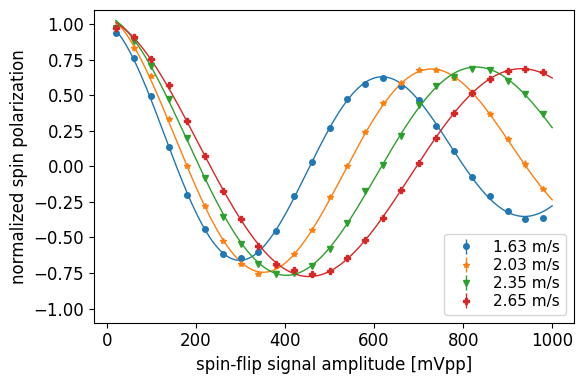

In [13]:
fig, ax = plt.subplots()

popt, perr = plotRabiAmplitudeScan('data/rabiAmplitudeScan_SF1_2500mV_0050mA_20220303/', ax, lc='C0', label='1.63 m/s', marker='o', ms=4, p0=(0.0015,1,-90,0,0.001,0))
popt, perr = plotRabiAmplitudeScan('data/rabiAmplitudeScan_SF1_3000mV_0050mA_20220303/', ax, lc='C1', label='2.03 m/s', marker='*', ms=4, p0=(0.0015,1,-90,0,0.001,0))
popt, perr = plotRabiAmplitudeScan('data/rabiAmplitudeScan_SF1_3500mV_0050mA_20220303/', ax, lc='C2', label='2.35 m/s', marker='v', ms=4, p0=(0.0015,1,-90,0,0.001,0))
popt, perr = plotRabiAmplitudeScan('data/rabiAmplitudeScan_SF1_4000mV_0050mA_20220303/', ax, lc='C3', label='2.65 m/s', marker='P', ms=4, p0=(0.001,1,-90,0,0.001,0))

ax.legend(loc='lower right')
ax.set(xlabel='spin-flip signal amplitude [mVpp]', ylabel='normalized spin polarization', ylim=(-1.1,1.1))

fig.set(dpi=100)
fig.tight_layout()

plt.show()

## Ramsey Measurements

### Frequency Scan

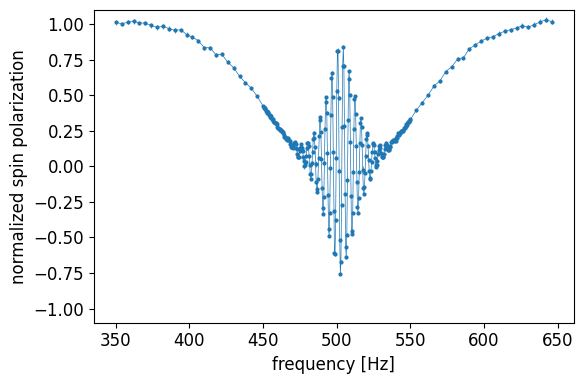

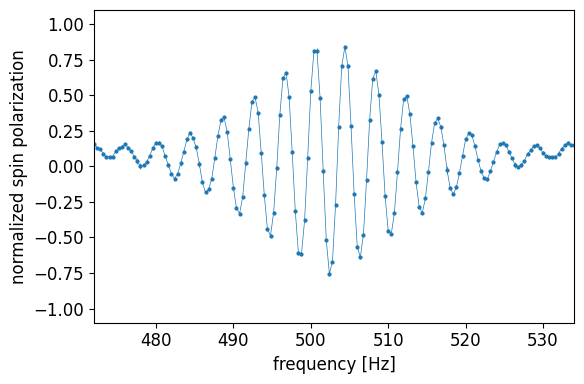

In [14]:
fig, ax = plt.subplots()

plotRamseyFrequencyScan('data/ramseyFrequencyScan_3500mV_0050mA_20220303/', ax)

ax.set(xlabel='frequency [Hz]', ylabel='normalized spin polarization', ylim=(-1.1,1.1))
fig.set(dpi=100)
fig.tight_layout()

plt.show()



fig, ax = plt.subplots()

plotRamseyFrequencyScan('data/ramseyFrequencyScan_3500mV_0050mA_20220303/', ax)

ax.set(xlabel='frequency [Hz]', ylabel='normalized spin polarization', xlim=(472,534), ylim=(-1.1,1.1))
fig.set(dpi=100)
fig.tight_layout()

plt.show()

### Phase Scan

proton phase: 120.3(3) deg
reduced chi-squared: 0.7

proton phase: 139.8(3) deg
reduced chi-squared: 4.5

proton phase: 180.3(3) deg
reduced chi-squared: 3.2



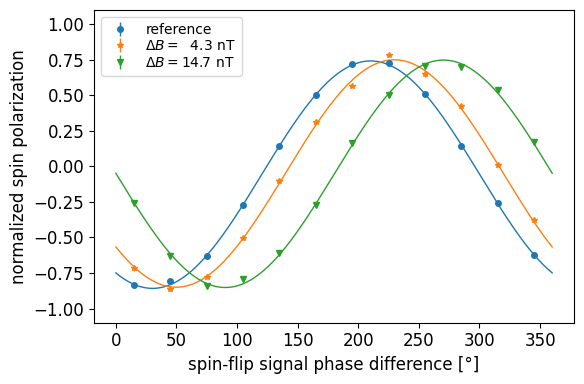

In [15]:
fig, ax = plt.subplots()

pPhase = []
popt,perr,By_0 = plotRamseyPhaseScan('data/ramseyPhaseScan_3500mV_0050-000mA_20220330/', ax=ax, lc='C0', marker='o', ms=4, label='reference')
pPhase.append([popt[1],perr[1]])
popt,perr,By_2 = plotRamseyPhaseScan('data/ramseyPhaseScan_3500mV_0050-020mA_20220330/', ax=ax, lc='C1', marker='*', ms=4, label='$\Delta B =$  4.3 nT')
pPhase.append([popt[1],perr[1]])
popt,perr,By_6 = plotRamseyPhaseScan('data/ramseyPhaseScan_3500mV_0050-060mA_20220330/', ax=ax, lc='C2', marker='v', ms=4, p0=(1,150,0), label='$\Delta B =$14.7 nT')
pPhase.append([popt[1],perr[1]])
pPhase = np.asarray(pPhase).T

ax.legend(fontsize=10)
ax.set(xlabel='spin-flip signal phase difference [°]', ylabel='normalized spin polarization', ylim=(-1.1,1.1))
fig.set(dpi=100)
fig.tight_layout()

plt.show()

In [16]:
pPhase = []
By = []

popt,perr,By_tmp = plotRamseyPhaseScan('data/ramseyPhaseScan_3500mV_0050-000mA_20220330/')
pPhase.append([popt[1],perr[1]]); By.append(By_tmp)
popt,perr,By_tmp = plotRamseyPhaseScan('data/ramseyPhaseScan_3500mV_0050-010mA_20220330/')
pPhase.append([popt[1],perr[1]]); By.append(By_tmp)
popt,perr,By_tmp = plotRamseyPhaseScan('data/ramseyPhaseScan_3500mV_0050-020mA_20220330/')
pPhase.append([popt[1],perr[1]]); By.append(By_tmp)
popt,perr,By_tmp = plotRamseyPhaseScan('data/ramseyPhaseScan_3500mV_0050-040mA_20220330/')
pPhase.append([popt[1],perr[1]]); By.append(By_tmp)
popt,perr,By_tmp = plotRamseyPhaseScan('data/ramseyPhaseScan_3500mV_0050-060mA_20220330/', p0=(1,150,0))
pPhase.append([popt[1],perr[1]]); By.append(By_tmp)
    
pPhase = np.asarray(pPhase).T
By = np.asarray(By).T

proton phase: 120.3(3) deg
reduced chi-squared: 0.7

proton phase: 130.0(3) deg
reduced chi-squared: 5.0

proton phase: 139.8(3) deg
reduced chi-squared: 4.5

proton phase: 160.8(3) deg
reduced chi-squared: 3.2

proton phase: 180.3(3) deg
reduced chi-squared: 3.2



4.1 +/- 0.1 deg/nT


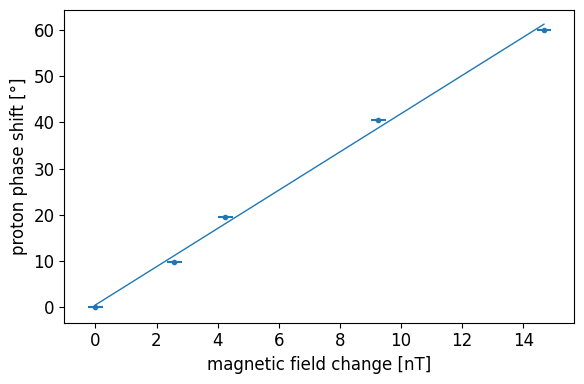

In [17]:
popt, pcov = np.polyfit(1e3*By[0], pPhase[0], 1, cov=True)
perr = np.sqrt(np.diag(pcov))
print('{:.1f} +/- {:.1f} deg/nT'.format(popt[0], perr[0]))

fig,ax = plt.subplots()
ax.errorbar((By[0]-By[0,0])*1e3, pPhase[0]-pPhase[0,0], pPhase[1], By[1]*1e3, fmt='C0.')
ax.plot((By[0]-By[0,0])*1e3, np.polyval(popt, 1e3*By[0])-pPhase[0,0], 'C0-', lw=1)
ax.set(xlabel='magnetic field change [nT]', ylabel='proton phase shift [°]')
fig.set(dpi=100)
fig.tight_layout()
plt.show()

## Stability

### Closed Shield

In [18]:
# path of data files
path = 'data/stability_20220209/'

# rate from original mdate of the files
Rc = 0.01151135117770809

# load preprocessed data
ramseyPhase_closedShield = np.load(path+'ramseyPhase_closedShield.npy')

# number of measurements
Nc = len(ramseyPhase_closedShield[0])

### Open Shield

In [19]:
# path of data files
path = 'data/stability_20220221/'

# rate from original mdate of the files
Ro = 0.01105442556383233

# load preprocessed data
ramseyPhase_openShield = np.load(path+'ramseyPhase_openShield.npy')

# number of measurements
No = len(ramseyPhase_openShield[0])

### Comparison

In [20]:
# values from the phase shift measurement
# ramseyPhaseScan_3500mV_0050-XXXmA_20220330
deg2nT = np.array([4.140838987512657, 0.1469288097661655])

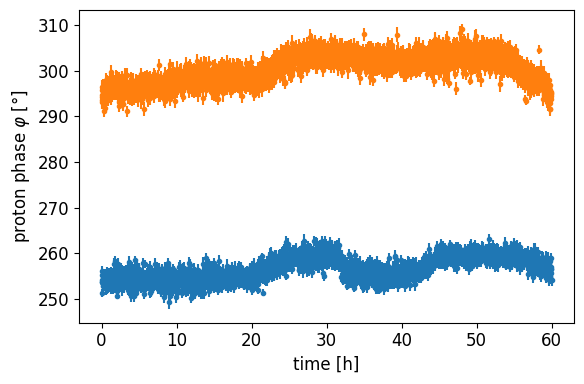

In [21]:
fig, ax = plt.subplots()

ax.errorbar(np.arange(Nc)/Rc/3600, ramseyPhase_closedShield[0], ramseyPhase_closedShield[1], fmt='C0.', label='full shield')
ax.errorbar(np.arange(No)/Ro/3600, ramseyPhase_openShield[0], ramseyPhase_openShield[1], fmt='C1.', label='open shield')

#ax.legend()
ax.set(xlabel=r'time [h]', ylabel=r'proton phase $\varphi$ [°]')

fig.set(dpi=100)
fig.tight_layout()

plt.show()

0.34498101527322467
0.08331186416896877
0.40691151853346064
0.098267892028781


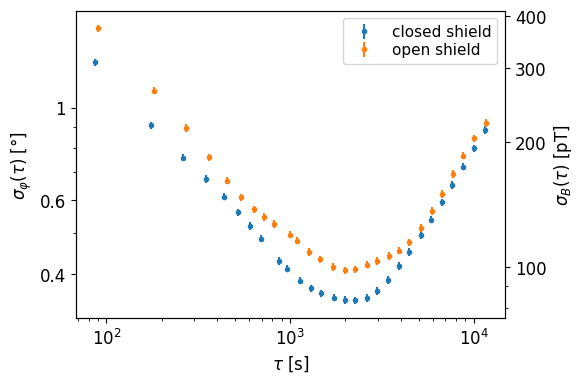

In [22]:
# get numerical values
(taus2, ad, ade, ns) = oadev(ramseyPhase_closedShield[0], rate=Rc, data_type='freq', taus='all')
print(ad.min())
print(ad.min()/deg2nT[0])

(taus2, ad, ade, ns) = oadev(ramseyPhase_openShield[0], rate=Ro, data_type='freq', taus='all')
print(ad.min())
print(ad.min()/deg2nT[0])


maxn = np.floor(np.log2(len(ramseyPhase_openShield[0]))) / 1.5
taus = 1/Ro*np.logspace(0, int(maxn), int(5*maxn+1), base=2.0)


fig, ax = plt.subplots()
ax2 = ax.twinx()

(taus2, ad, ade, ns) = oadev(ramseyPhase_closedShield[0], rate=Rc, data_type='freq', taus=taus)
ax.errorbar(taus2, ad, ade, fmt='C0.', label='closed shield')
ax2.errorbar(taus2, 1e3*ad/deg2nT[0], 1e3*ade/deg2nT[0], fmt='C2.', ms=0, lw=0)

(taus2, ad, ade, ns) = oadev(ramseyPhase_openShield[0], rate=Ro, data_type='freq', taus=taus)
ax.errorbar(taus2, ad, ade, fmt='C1.', label='open shield')
ax2.errorbar(taus2, 1e3*ad/deg2nT[0], 1e3*ade/deg2nT[0], fmt='C2.', ms=0, lw=0)

ax.legend()
ax.set(xlabel=r'$\tau$ [s]', ylabel=r'$\sigma_{\varphi}(\tau)$ [°]', xscale='log', yscale='log')
ticks = (0.4,0.6,1)
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)

ax2.set(ylabel=r'$\sigma_{B}(\tau)$ [pT]', yscale='log')
ticks = (100,200,300,400)
ax2.set_yticks(ticks)
ax2.set_yticklabels(ticks)

fig.set(dpi=100)
fig.tight_layout()

plt.show()